## 3-layers NN for Fashion MNIST : PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import random
import numpy as np
import matplotlib.pyplot as plt

## Step 0. Device Stepup

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print("Device : ", device)

Device :  cpu


Hyperparameters

In [3]:
learning_rate = 1e-3
batch_size = 100
epochs = 30

### Step 1. Data -  target class : 10

In [4]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print('train_data :', train_data)
print('test_data :', test_data)

train_data : Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
test_data : Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


### Step 2. NN Model (input = 784, hidden 1,2 = 256, output = 10 with softmax function)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        logits = self.model(x)
        return logits

model = NeuralNetwork().to(device)

### Step 3. Loss and Optimizer

In [7]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step 4. & 5. Train/Test the model

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    correct /= size
    print(f"Train - Avg loss: {train_loss:>8f},  Accuracy: {(100*correct):>0.1f}%", end = "  ")

    return train_loss, correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.view(-1, 28 * 28).to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test - Avg loss: {test_loss:>8f}  Accuracy: {(100*correct):>0.1f}%")

    return test_loss, correct

In [9]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for t in range(epochs):
    print(f"Epoch {t+1} :", end= "  ")
    loss, acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)

    loss_t, acc_t = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(loss_t)
    test_acc.append(acc_t)

print("Done!")

Epoch 1 :  Train - Avg loss: 0.533163,  Accuracy: 81.0%  Test - Avg loss: 0.430828  Accuracy: 84.7%
Epoch 2 :  Train - Avg loss: 0.375035,  Accuracy: 86.3%  Test - Avg loss: 0.378352  Accuracy: 86.4%
Epoch 3 :  Train - Avg loss: 0.333023,  Accuracy: 87.7%  Test - Avg loss: 0.355770  Accuracy: 87.5%
Epoch 4 :  Train - Avg loss: 0.306162,  Accuracy: 88.7%  Test - Avg loss: 0.347805  Accuracy: 87.4%
Epoch 5 :  Train - Avg loss: 0.285519,  Accuracy: 89.4%  Test - Avg loss: 0.345011  Accuracy: 87.5%
Epoch 6 :  Train - Avg loss: 0.270669,  Accuracy: 89.9%  Test - Avg loss: 0.347324  Accuracy: 87.5%
Epoch 7 :  Train - Avg loss: 0.258088,  Accuracy: 90.4%  Test - Avg loss: 0.341740  Accuracy: 87.9%
Epoch 8 :  Train - Avg loss: 0.242924,  Accuracy: 90.9%  Test - Avg loss: 0.353841  Accuracy: 87.8%
Epoch 9 :  Train - Avg loss: 0.232179,  Accuracy: 91.2%  Test - Avg loss: 0.354893  Accuracy: 87.4%
Epoch 10 :  Train - Avg loss: 0.220908,  Accuracy: 91.6%  Test - Avg loss: 0.341772  Accuracy: 88.3%

### Plot the Training/Test Loss

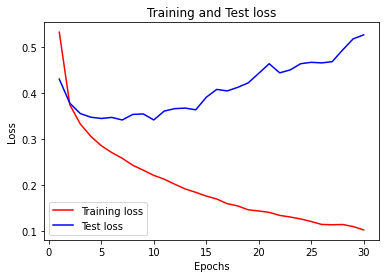

In [10]:
epochs = np.arange(1, epochs+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot the Training/Test Accuracy

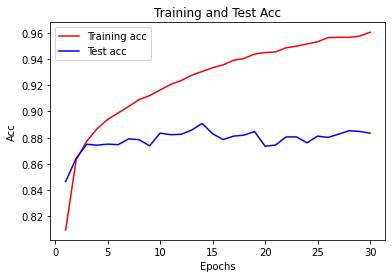

In [11]:
plt.clf()   # 그래프를 초기화합니다
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()